In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.graphics.regressionplots as smg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from statsmodels.tools import add_constant
import requests
from io import StringIO

###Import training and validation data

In [2]:
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/train_data.csv?token=GHSAT0AAAAAACC4ZCNKRKQBWCGNKARGMRZ2ZGRO5TA"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'train' variable
    train = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'train' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/val_data.csv?token=GHSAT0AAAAAACC4ZCNL6CLEYWQ7I647KVRWZGRO57A"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'valid' variable
    valid = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'valid' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/test_data.csv?token=GHSAT0AAAAAACC4ZCNKRR63P6ASKCCXTCAWZGRO6HQ"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'train' variable
    test = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'test' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

Dataset downloaded and loaded into 'train' successfully.
Dataset downloaded and loaded into 'valid' successfully.
Dataset downloaded and loaded into 'test' successfully.


In [3]:
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

possible_values = [-1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00]

def round_to_nearest(value, possible_values):
    return min(possible_values, key=lambda x: abs(x - value))

def calculate_accuracy(y_true, y_pred):
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_val, pred_val in zip(y_true, y_pred):
        if true_val == pred_val:
            correct_predictions += 1
            
    accuracy = correct_predictions / total_predictions
    return accuracy

###Start with basic linear models

###Best Variable Selection

In [4]:
# Create a copy of the 'train' DataFrame
test_data = train.copy()

# Create an empty DataFrame to store the results
variable_selection_results = pd.DataFrame(columns=['Variable', 't-statistic', 'p-value'])

# Convert 'Date' column to numeric temporarily
test_data['Date_numeric'] = pd.to_numeric(test_data['Date'], errors='coerce')

# Iterate over each predictor variable in the 'test_data' dataset
for predictor_variable in test_data.columns:
    if predictor_variable != 'Difference' and predictor_variable != 'Date':
        # Convert predictor variable to numeric type
        test_data[predictor_variable] = pd.to_numeric(test_data[predictor_variable], errors='coerce')
        
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_data[predictor_variable], test_data['Difference'], nan_policy='omit')
        
        # Store the results in the DataFrame
        variable_selection_results = variable_selection_results.append({
            'Variable': predictor_variable,
            't-statistic': t_stat,
            'p-value': p_value
        }, ignore_index=True)

# Sort the results by p-value in ascending order
variable_selection_results = variable_selection_results.sort_values(by='p-value', ascending=True)

# Convert 'Date_numeric' back to a date
test_data['Date_numeric'] = pd.to_datetime(test_data['Date_numeric'], errors='coerce')

# Print the variable selection results
print(variable_selection_results)

C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

                             Variable t-statistic   p-value
17   Durable Goods Orders_RollingMean   87.146253       0.0
3                Durable Goods Orders   86.335363       0.0
2                        Retail Sales   55.866412       0.0
16           Retail Sales_RollingMean   55.603675       0.0
11       Standardized Sentiment Score   31.369551       0.0
..                                ...         ...       ...
86                        susceptible   -0.089934  0.928387
57                             lacked   -0.089934  0.928387
69                            protest   -0.089934  0.928387
55                     intermittently   -0.089934  0.928387
100                      Date_numeric          --        --

[101 rows x 3 columns]


C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_10392\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

###Subset Selection

In [5]:
top_15_variable_names = variable_selection_results['Variable'].head(15)
top_15_variable_names

17    Durable Goods Orders_RollingMean
3                 Durable Goods Orders
2                         Retail Sales
16            Retail Sales_RollingMean
11        Standardized Sentiment Score
10                          Word Count
7                   Positive Frequency
76                             sharply
8                   Negative Frequency
26                             concern
30                             decline
53                            improved
6                  Net Sentiment Score
43                             dropped
85                            stronger
Name: Variable, dtype: object

In [6]:
# Add the selected independent variables to the model
X = sm.add_constant(train[top_15_variable_names])

# Fit the OLS model
model = sm.OLS(train['Difference'], X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     5.282
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           5.69e-08
Time:                        15:17:00   Log-Likelihood:                 67.806
No. Observations:                 192   AIC:                            -107.6
Df Residuals:                     178   BIC:                            -62.01
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [7]:
# Add the selected independent variables to the model
X = sm.add_constant(train[top_15_variable_names])

# Fit the OLS model
model = sm.OLS(train['Difference'], X).fit()

# Get the fitted values from the model for the training set
y_train_pred = model.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = sm.add_constant(valid[top_15_variable_names])
y_valid_pred = model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [8]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0332031 |        0.0703125 |
+--------------+----------------+------------------+
| RMSE         |      0.182217  |        0.265165  |
+--------------+----------------+------------------+
| R^2          |      0.170697  |       -0.081803  |
+--------------+----------------+------------------+
| Adjusted R^2 |     -0.703193  |       -2.5545    |
+--------------+----------------+------------------+
| Accuracy     |      0.677083  |        0.541667  |
+--------------+----------------+------------------+


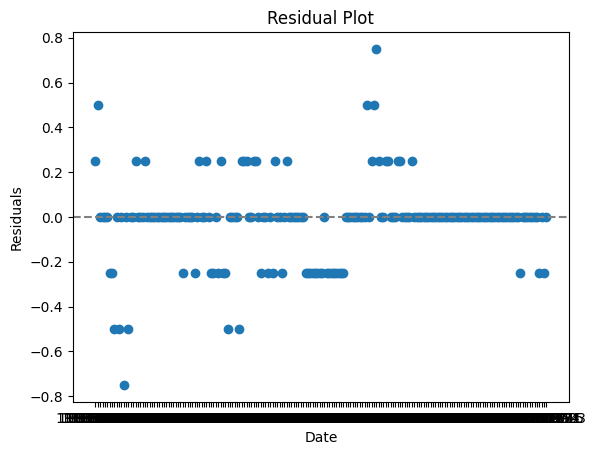

In [9]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###All variables

In [10]:
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/train_data.csv?token=GHSAT0AAAAAACC4ZCNKZIAXMR5KKB4KITS6ZGRKDJQ"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'train' variable
    train = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'train' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/val_data.csv?token=GHSAT0AAAAAACC4ZCNKO253HPZJKMLAVTCSZGRKDXQ"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'valid' variable
    valid = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'valid' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# The URL of the raw dataset on GitHub
url = "https://raw.githubusercontent.com/abactat/BC-Project/main/data/processed/test_data.csv?token=GHSAT0AAAAAACC4ZCNLZXIWKTR7BZE2NKKIZGRKECA"

# Send an HTTP GET request to fetch the content of the raw dataset
response = requests.get(url)

# Check if the request was successful (status code 200 means success)
if response.status_code == 200:
    # Read the content as a pandas DataFrame and assign it to the 'train' variable
    test = pd.read_csv(StringIO(response.text))
    print("Dataset downloaded and loaded into 'test' successfully.")
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")
    
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

Dataset downloaded and loaded into 'train' successfully.
Dataset downloaded and loaded into 'valid' successfully.
Dataset downloaded and loaded into 'test' successfully.


In [11]:
# Add the selected independent variables to the model
X_train = sm.add_constant(X_train)  # Add constant for the intercept term
model = sm.OLS(y_train, X_train).fit()

# Get the fitted values from the model for the training set
y_train_pred = model.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [12]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00651042 |        0.0572917 |
+--------------+----------------+------------------+
| RMSE         |     0.0806872  |        0.239357  |
+--------------+----------------+------------------+
| R^2          |     0.837391   |        0.118531  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.662411   |        1.26676   |
+--------------+----------------+------------------+
| Accuracy     |     0.895833   |        0.541667  |
+--------------+----------------+------------------+


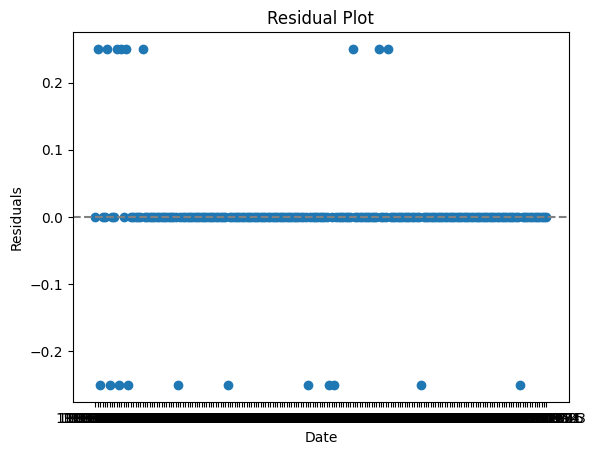

In [13]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Reverse Variable Selection (p-value)

In [14]:
def perform_reverse_variable_selection(X, y, threshold):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    while True:
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the predictor variable with the highest p-value
        max_p_value = p_values.max()
        if max_p_value <= threshold:
            break
        
        # Remove the predictor variable with the highest p-value
        max_p_var = p_values.idxmax()
        X = X.drop(max_p_var, axis=1)
        
        # Fit the model with the updated set of predictor variables
        model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

# Perform reverse variable selection with a threshold of 0.05
threshold = 0.05
model_reverse_selection = perform_reverse_variable_selection(X_train, y_train, threshold)

# Print the summary of the linear regression results after variable selection
print(model_reverse_selection.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     44.71
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           3.54e-53
Time:                        15:17:07   Log-Likelihood:                 192.66
No. Observations:                 192   AIC:                            -351.3
Df Residuals:                     175   BIC:                            -295.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [15]:
# Extract the remaining variables in X_train after variable selection
selected_variables = model_reverse_selection.model.exog_names[1:]  # Exclude the constant term
X_train = train[selected_variables]

# Add the selected independent variables to the model
X_train = sm.add_constant(X_train)  # Add constant for the intercept term
model = sm.OLS(y_train, X_train).fit()

# Get the fitted values from the model for the training set
y_train_pred = model.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = valid[selected_variables]  # Use the selected variables in the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [16]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00911458 |        0.0364583 |
+--------------+----------------+------------------+
| RMSE         |     0.0954703  |        0.190941  |
+--------------+----------------+------------------+
| R^2          |     0.772348   |        0.439065  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.739632   |       13.9015    |
+--------------+----------------+------------------+
| Accuracy     |     0.869792   |        0.666667  |
+--------------+----------------+------------------+


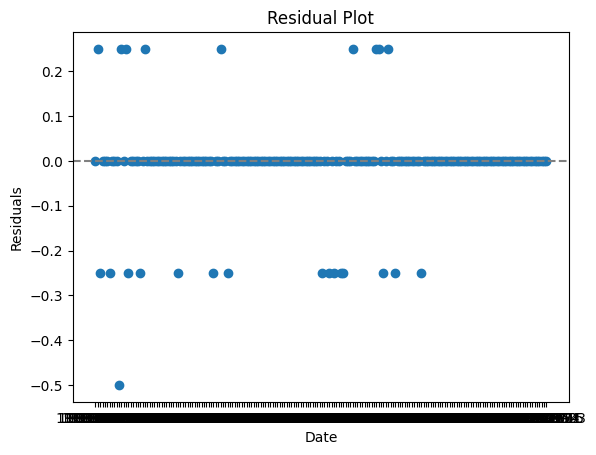

In [17]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Reverse variable selection (AICc) version

In [18]:
def perform_reverse_variable_selection(X, y, threshold):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    while True:
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the predictor variable with the highest p-value
        max_p_value = p_values.max()
        if max_p_value <= threshold:
            break
        
        # Remove the predictor variable with the highest p-value
        max_p_var = p_values.idxmax()
        X = X.drop(max_p_var, axis=1)
        
        # Fit the model with the updated set of predictor variables
        model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

# Perform reverse variable selection with a threshold of 0.05
threshold = 0.05
model_reverse_selection = perform_reverse_variable_selection(X_train, y_train, threshold)

# Print the summary of the linear regression results after variable selection
print(model_reverse_selection.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     44.71
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           3.54e-53
Time:                        15:17:08   Log-Likelihood:                 192.66
No. Observations:                 192   AIC:                            -351.3
Df Residuals:                     175   BIC:                            -295.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [19]:
len(selected_variables)

23

In [20]:
# Extract the remaining variables in X_train after variable selection based on AICc
selected_variables = model_reverse_selection.model.exog_names[1:]  # Exclude the constant term
X_train = train[selected_variables]
y_train = train['Difference']  # Use the 'Difference' variable as the target

# Add the constant term for the intercept (if needed)
X_train = sm.add_constant(X_train)

# Initialize and fit the Ridge Regression model with the selected variables
ridge_alpha = 1.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, y_train)

# Get the fitted values from the model for the training set
y_train_pred = ridge_model.predict(X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = valid[selected_variables]  # Use the selected variables in the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = ridge_model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [21]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00813802 |        0.0390625 |
+--------------+----------------+------------------+
| RMSE         |     0.090211   |        0.197642  |
+--------------+----------------+------------------+
| R^2          |     0.796739   |        0.398998  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.767528   |       14.823     |
+--------------+----------------+------------------+
| Accuracy     |     0.869792   |        0.625     |
+--------------+----------------+------------------+


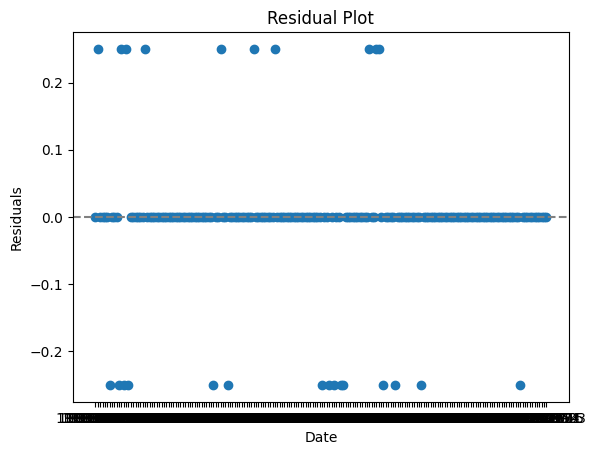

In [22]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Ridge regression

In [23]:
# Initialize and fit the Ridge Regression model
ridge_alpha = 1.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, y_train)

# Get the fitted values from the model for the training set
y_train_pred = ridge_model.predict(X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Add the constant term for the intercept in X_valid
X_valid = sm.add_constant(X_valid)

# Make predictions on the validation set
y_valid_pred = ridge_model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [24]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00813802 |        0.0390625 |
+--------------+----------------+------------------+
| RMSE         |     0.090211   |        0.197642  |
+--------------+----------------+------------------+
| R^2          |     0.796739   |        0.398998  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.767528   |       14.823     |
+--------------+----------------+------------------+
| Accuracy     |     0.869792   |        0.625     |
+--------------+----------------+------------------+


In [25]:
# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]  # List of alpha values (regularization strength)
}

# Create the Ridge Regression model
ridge_model = Ridge()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV to the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_alpha = grid_search.best_params_['alpha']

# Add the constant term for the intercept in X_train and X_valid
X_train_with_const = sm.add_constant(X_train)
X_valid_with_const = sm.add_constant(X_valid)

# Initialize the Ridge Regression model with the best hyperparameters
best_ridge_model = Ridge(alpha=best_alpha)

# Fit the model to the training data with the best hyperparameters
best_ridge_model.fit(X_train_with_const, y_train)

# Get the fitted values from the model for the training set
y_train_pred = best_ridge_model.predict(X_train_with_const)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set with the best model
y_valid_pred = best_ridge_model.predict(X_valid_with_const)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [26]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0185547 |        0.0625    |
+--------------+----------------+------------------+
| RMSE         |      0.136216  |        0.25      |
+--------------+----------------+------------------+
| R^2          |      0.536566  |        0.0383973 |
+--------------+----------------+------------------+
| Adjusted R^2 |      0.469964  |       23.1169    |
+--------------+----------------+------------------+
| Accuracy     |      0.78125   |        0.625     |
+--------------+----------------+------------------+


In [27]:
# Initialize and fit the Ridge Regression model
ridge_alpha = 5.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, y_train)

# Get the fitted values from the model for the training set
y_train_pred = ridge_model.predict(X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Add the constant term for the intercept in X_valid
X_valid = sm.add_constant(X_valid)

# Make predictions on the validation set
y_valid_pred = ridge_model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [28]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0133464 |        0.0442708 |
+--------------+----------------+------------------+
| RMSE         |      0.115526  |        0.210406  |
+--------------+----------------+------------------+
| R^2          |      0.666653  |        0.318865  |
+--------------+----------------+------------------+
| Adjusted R^2 |      0.618746  |       16.6661    |
+--------------+----------------+------------------+
| Accuracy     |      0.802083  |        0.625     |
+--------------+----------------+------------------+
